In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

In [2]:
URL_BASE = 'https://raw.githubusercontent.com/ab-courses/simulator-ab-datasets/main/2022-04-01/'
def read_database(file_name):
    return pd.read_csv(os.path.join(URL_BASE, file_name))


In [3]:
df_sales = read_database('2022-04-01T12_df_sales.csv')
df_web_logs = read_database('2022-04-01T12_df_web_logs.csv')
df_sales['date'] = pd.to_datetime(df_sales['date'])
df_web_logs['date'] = pd.to_datetime(df_web_logs['date'])

In [4]:
df_sales.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203847 entries, 0 to 203846
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   sale_id      203847 non-null  int64         
 1   date         203847 non-null  datetime64[ns]
 2   count_pizza  203847 non-null  int64         
 3   count_drink  203847 non-null  int64         
 4   price        203847 non-null  int64         
 5   user_id      203847 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 9.3+ MB


In [5]:
df_sales.head()

,sale_id,date,count_pizza,count_drink,price,user_id
0,1000001,2022-02-04 10:00:24,1,0,720,1c1543
1,1000002,2022-02-04 10:02:28,1,1,930,a9a6e8
2,1000003,2022-02-04 10:02:35,3,1,1980,23420a
3,1000004,2022-02-04 10:03:06,1,1,750,3e8ed5
4,1000005,2022-02-04 10:03:23,1,1,870,cbc468


In [6]:
df_sales.describe()

,sale_id,count_pizza,count_drink,price
count,2.038470e+05,203847.000000,203847.000000,203847.000000
mean,1.101924e+06,1.675879,0.367226,1206.014364
std,5.884570e+04,1.065426,0.584551,778.476884
min,1.000001e+06,1.000000,0.000000,540.000000
25%,1.050962e+06,1.000000,0.000000,720.000000
50%,1.101924e+06,1.000000,0.000000,840.000000
75%,1.152886e+06,2.000000,1.000000,1500.000000
max,1.203847e+06,18.000000,7.000000,13230.000000


In [7]:
df_web_logs.head()

,user_id,page,date,load_time
0,f25239,m,2022-02-03 23:45:37,80.8
1,06d6df,m,2022-02-03 23:49:56,70.5
2,06d6df,m,2022-02-03 23:51:16,89.7
3,f25239,m,2022-02-03 23:51:43,74.4
4,697870,m,2022-02-03 23:53:12,66.8


In [8]:
df_web_logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1964507 entries, 0 to 1964506
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   user_id    object        
 1   page       object        
 2   date       datetime64[ns]
 3   load_time  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 60.0+ MB


In [9]:
df_web_logs.describe()

,load_time
count,1.964507e+06
mean,7.396452e+01
std,1.107026e+02
min,0.000000e+00
25%,6.180000e+01
50%,7.000000e+01
75%,7.810000e+01
max,4.197500e+03


### Merging tables

How often does a user visit the site and not buy anything that day?

In [10]:
df_web_logs['day']=df_web_logs['date'].dt.date
df_sales['day']=df_sales['date'].dt.date

In [11]:
df_web_logs.head(2)

,user_id,page,date,load_time,day
0,f25239,m,2022-02-03 23:45:37,80.8,2022-02-03
1,06d6df,m,2022-02-03 23:49:56,70.5,2022-02-03


In [12]:
user_day_web=df_web_logs[['user_id','day','page']].groupby(['user_id','day']).count()
user_day_sale=df_sales[['user_id','day','price']].groupby(['user_id','day']).sum()
user_day_web.head(2)

page
user_id day             
000096  2022-03-04     8
        2022-03-22     7

In [13]:
user_day_sale.head(2)

price
user_id day              
000096  2022-03-04    720
        2022-03-22    720

In [14]:
df2=pd.merge(
    user_day_web,
    user_day_sale,
    how='outer',
    left_index=True,
    right_index=True
    )

In [15]:
df2.head()

page  price
user_id day                    
000096  2022-03-04     8  720.0
        2022-03-22     7  720.0
0000d4  2022-02-28     9  720.0
        2022-03-27    10  720.0
0000de  2022-02-11     6  660.0

In [16]:
df2.isnull().mean()
# 33% of customers visited the website, but didn't buy anything 

page     0.000000
price    0.329802
dtype: float64

### Tasks

In [17]:
# 40% of orders have a value greater than 1000  each. Suppose a new order costs more than 1000  with probability 0.4. 
# Estimate the probability that out of 100 new orders 50 or more cost more than 1000 .
values=np.random.binomial(100,0.4,size=1000000)
answer=(values>=50).mean()
print('answer',round(answer,3))


answer 0.027


(array([8.90000e+01, 2.33200e+03, 3.75100e+04, 1.39581e+05, 3.64085e+05,
        2.77253e+05, 1.52138e+05, 2.37800e+04, 3.14400e+03, 8.80000e+01]),
 array([18. , 22.5, 27. , 31.5, 36. , 40.5, 45. , 49.5, 54. , 58.5, 63. ]),
 <BarContainer object of 10 artists>)

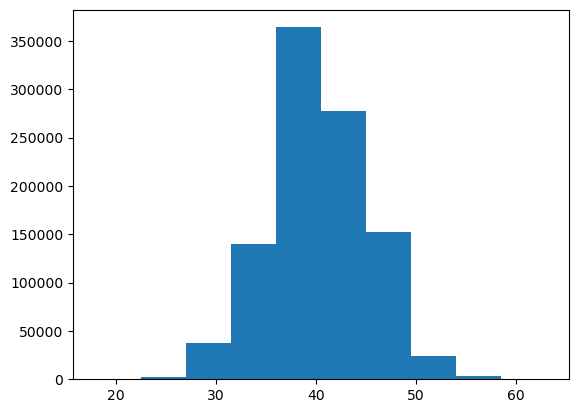

In [18]:
plt.hist(values)

#### Identify the top 3 products by total revenue.

In [19]:

URL_BASE = 'https://raw.githubusercontent.com/ab-courses/simulator-ab-datasets/main/2022-04-01/'
def read_database(file_name):
    return pd.read_csv(os.path.join(URL_BASE, file_name))

df_sales_detail = read_database('2022-04-01T12_df_sales_detail.csv')
df_sales_detail['date']=pd.to_datetime(df_sales_detail['date'])



In [20]:
df_sales_detail.head(2)

,sale_id,good,price,date,user_id
0,1000001,mexican pizza,720,2022-02-04 10:00:24,1c1543
1,1000002,chefs pizza,840,2022-02-04 10:02:28,a9a6e8


In [21]:
top_revenue=(
    df_sales_detail.groupby('good')['price'].sum().sort_values(ascending=False).iloc[:3].index.tolist()
    ) 
print("top 3 goods by revenue",top_revenue)

top 3 goods by revenue ['chefs pizza', 'double pepperoni pizza', 'chicken bbq pizza']


### Estimate the average time that passes from a user entering the site to making a purchase. 
We will assume that a visit to the site is a purchase if it was made not earlier than two hours before the purchase.

In [22]:
from datetime import timedelta

In [23]:
df3=pd.merge(
    df_sales[['user_id','date']].rename(columns={'date':'date_sale'}),
    df_web_logs[['user_id','date']].rename(columns={'date':'date_enter'}),
    on='user_id',
    how='inner'
)

In [24]:
df3.head()

,user_id,date_sale,date_enter
0,1c1543,2022-02-04 10:00:24,2022-02-04 09:50:02
1,1c1543,2022-02-04 10:00:24,2022-02-04 09:51:16
2,1c1543,2022-02-04 10:00:24,2022-02-04 09:52:58
3,1c1543,2022-02-04 10:00:24,2022-02-04 09:57:04
4,1c1543,2022-02-04 10:00:24,2022-02-04 09:57:28


In [25]:
# delete rows where customer visited site 2 hours (& more) before bying 
df3=df3[
    (df3['date_enter']>=df3['date_sale']-timedelta(hours=2)) & (df3['date_enter']<df3['date_sale'])
].copy()

In [26]:
# time of the first visit
df3_first_visit=df3.groupby(['user_id','date_sale'])[['date_enter']].min().reset_index()
# calculate time in seconds
df3_first_visit['delta']=(df3_first_visit['date_sale']-df3_first_visit['date_enter']).dt.total_seconds()
# calculate average time in minutes 

answer=round(df3_first_visit['delta'].mean()/60)
print('average time that passes from a user entering the site to making a purchase:',answer, 'min')

average time that passes from a user entering the site to making a purchase: 17 min


In [27]:
### function to get data 
def get_data_subset(df, begin_date, end_date, user_ids=None, columns=None):
    if begin_date:
        df = df[df['date'] >= begin_date]
    if end_date:
        df = df[df['date'] < end_date]
    if user_ids:
        df = df[df['user_id'].isin(user_ids)]
    if columns:
        df = df[columns]
    return df.copy()

In [28]:
from datetime import datetime

In [29]:
df_example=get_data_subset(df_sales,datetime(2022,3,1),datetime(2022,4,23))
df_example.head()

,sale_id,date,count_pizza,count_drink,price,user_id,day
91777,1091778,2022-03-01 10:00:29,3,2,2130,043908,2022-03-01
91778,1091779,2022-03-01 10:00:36,2,1,1500,ad7128,2022-03-01
91779,1091780,2022-03-01 10:02:11,4,0,2700,79ab41,2022-03-01
91780,1091781,2022-03-01 10:04:55,1,0,840,3f94bc,2022-03-01
91781,1091782,2022-03-01 10:05:49,3,0,2160,7cbf72,2022-03-01


In [30]:
def get_response_time(df_web_logs, begin_date, end_date):
    return (
        get_data_subset(df_web_logs, begin_date, end_date, None, ['user_id', 'load_time'])
        .rename(columns={'load_time': 'metric'})
        [['user_id', 'metric']]
    )

    
df_example2=get_response_time(df_web_logs,datetime(2022,3,1),datetime(2022,4,23))
df_example2.head()

,user_id,metric
885082,434cf2,69.8
885083,80fa93,86.3
885084,434cf2,58.0
885085,a0aaab,85.2
885086,a22f92,92.5


In [31]:
def get_revenue_web(df_sales, df_web_logs, begin_date, end_date):
    df_users = (
        get_data_subset(df_web_logs, begin_date, end_date, None, ['user_id'])
        .drop_duplicates()
    )
    df = (
        get_data_subset(df_sales, begin_date, end_date, None, ['user_id', 'price'])
        .groupby('user_id')[['price']].sum().reset_index() 
        .rename(columns={'price': 'metric'})
    )
    df = pd.merge(df_users, df, on='user_id', how='left').fillna(0)
    return df[['user_id', 'metric']]

In [32]:
df_example3=get_revenue_web(df_sales, df_web_logs,datetime(2022,3,1),datetime(2022,4,23))
df_example3.head()

,user_id,metric
0,434cf2,3150.0
1,80fa93,0.0
2,a0aaab,0.0
3,a22f92,0.0
4,b5f198,0.0


In [33]:
# get revenue for all users 

def get_revenue_all(df_sales, df_web_logs, begin_date, end_date):
    df_users = (
        get_data_subset(df_web_logs, None, end_date, None, ['user_id'])
        .drop_duplicates()
    )
    df = (
        get_data_subset(df_sales, begin_date, end_date, None, ['user_id', 'price'])
        .groupby('user_id')[['price']].sum().reset_index() 
        .rename(columns={'price': 'metric'})
    )
    df = pd.merge(df_users, df, on='user_id', how='left').fillna(0)
    return df[['user_id', 'metric']]

In [34]:
df_example4=get_revenue_all(df_sales, df_web_logs,datetime(2022,3,1),datetime(2022,4,23))
df_example4.head()

,user_id,metric
0,f25239,1560.0
1,06d6df,1470.0
2,697870,840.0
3,2edd8e,0.0
4,25025e,0.0


## Hypothesis testing

### Student's t-distribution

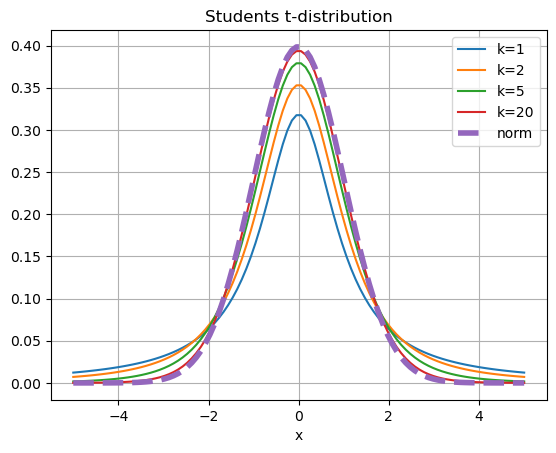

In [35]:
# Student's t-distribution
X = np.linspace(-5,5,100)
list_k=[1,2,5,20]
for k in list_k:
    Y=stats.t.pdf(X,k)
    plt.plot(X,Y,label=f'k={k}')
Y=stats.norm.pdf(X,0,1)
plt.plot(X,Y,'--',label='norm', linewidth=4)
plt.legend()
plt.title('Students'' t-distribution')
plt.xlabel('x')
plt.grid()
plt.show()


### Student's test 

In [36]:
def get_student_parameter(data_one: np.array, data_two: np.array) -> float:
    """Вычисляет параметр функции распределения Стьюдента."""
    len_one, len_two = len(data_one), len(data_one)
    std_one, std_two = np.std(data_one), np.std(data_two)
    k = (
        ((std_one ** 2) / len_one + (std_two ** 2) / len_two) ** 2
        / (
            (std_one ** 4) / ((len_one ** 2) * (len_one - 1))
            + (std_two ** 4) / ((len_two ** 2) * (len_two - 1))
        )
    )
    return k


def get_ttest_statistic(data_one: np.array, data_two: np.array) -> float:
    """Считает статистику Стьюдента"""
    len_one, len_two = len(data_one), len(data_two)
    mean_one, mean_two = np.mean(data_one), np.mean(data_two)
    std_one, std_two = np.std(data_one, ddof=1), np.std(data_two, ddof=1)
    t = (mean_two - mean_one) / np.sqrt((std_two**2 / len_two) + (std_one**2 / len_one))
    return t

In [37]:
#Compare the results with the finished implementation of the test
sample_size = 100
alpha = 0.05

np.random.seed(44)
data_control = np.random.normal(1, 1, sample_size)
data_pilot = np.random.normal(1.2, 1, sample_size)

k = get_student_parameter(data_control, data_pilot)
print(f'student_parameter = {k}')

critical_region_bounds = stats.t.ppf([alpha/2, 1 - alpha/2], df=k)
print(f'critical_region_bounds = {critical_region_bounds}')

ttest_statistic = get_ttest_statistic(data_control, data_pilot)
print(f'ttest_statistic = {ttest_statistic}')

pvalue = stats.t.cdf(-np.abs(ttest_statistic), df=k) * 2
print(f'pvalue = {pvalue}')
ttest_statistic_real, pvalue_real = stats.ttest_ind(data_pilot, data_control)
print(f'stats.ttest_ind = {stats.ttest_ind(data_pilot, data_control)}')
assert np.isclose(ttest_statistic_real, ttest_statistic, 1e-9), 'Calculation is correct'


student_parameter = 196.53643393447297
critical_region_bounds = [-1.97210778  1.97210778]
ttest_statistic = 1.8203056424009751
pvalue = 0.0702335577441075
stats.ttest_ind = Ttest_indResult(statistic=1.8203056424009751, pvalue=0.07022230781028711)


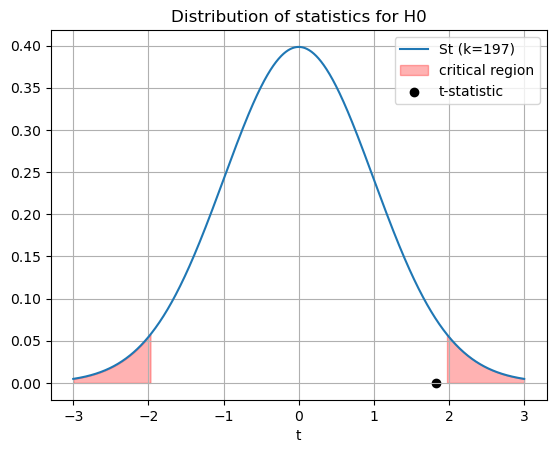

In [38]:
#critical areas of the criterion
X = np.linspace(-3, 3, 1000)
Y = stats.t.pdf(X, k)

plt.plot(X, Y, label=f'St (k={k:0.0f})')

critical_mask_list = [X < critical_region_bounds[0], X > critical_region_bounds[1]]
for idx, mask in enumerate(critical_mask_list):
    X_ = X[mask]
    Y_upper = Y[mask]
    Y_down = np.zeros(len(Y_upper))
    plt.fill_between(
        X_, Y_down, Y_upper,
        color='r', alpha=0.3,
        label='critical region' if idx==0 else ''
    )

plt.scatter([ttest_statistic], [0], color='k', label='t-statistic')

plt.title('Distribution of statistics for H0')
plt.xlabel('t')
plt.legend()
plt.grid()
plt.show()


### Two-sided and one-sided criteria

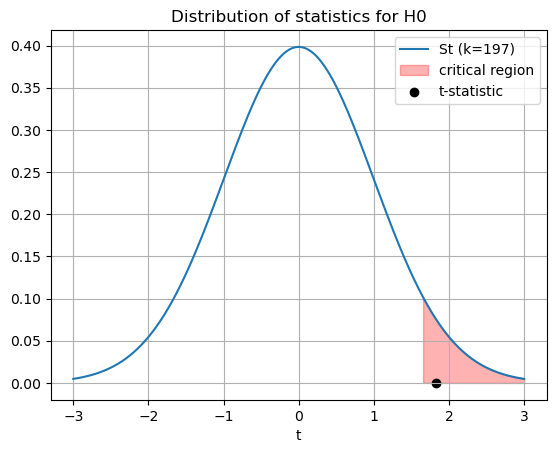

In [39]:
#Let's build the critical region of the one-sided criterion.
sample_size = 100
alpha = 0.05

k = get_student_parameter(data_control, data_pilot)
critical_region_bound = stats.t.ppf([1 - alpha], df=k)


X = np.linspace(-3, 3, 1000)
Y = stats.t.pdf(X, k)

plt.plot(X, Y, label=f'St (k={k:0.0f})')

mask = X > critical_region_bound
X_ = X[mask]
Y_upper = Y[mask]
Y_down = np.zeros(len(Y_upper))
plt.fill_between(
    X_, Y_down, Y_upper,
    color='r', alpha=0.3,
    label='critical region'
)

plt.scatter([ttest_statistic], [0], color='k', label='t-statistic')

plt.title('Distribution of statistics for H0')
plt.xlabel('t')
plt.legend()
plt.grid()
plt.show()

### P-value 

In [40]:
x=np.random.normal(0,1,100)
y=np.random.normal(0.4,1,100)
stats.ttest_ind(x,y)

Ttest_indResult(statistic=-5.100310939750893, pvalue=7.909852153789627e-07)